# Film Recommendation Engine


This notebook aims at building a recommendation engine from the content of the movie_metadata.csv dataset. This dataset contains around 5000 movies and TV series, and their description has been retrieved from the public IMDB database. Basically, the engine will work as follows: after the user has provided the name of a film he liked, the engine should be able to select in the database a list of 5 films that the user will enjoy. In practice, recommendation engines are of three kinds:
popularity-based engines: usually the most simple to implement be also the most impersonal
content-based engines: the recommendations are based on the description of the products
collaborative filtering engines: records from various users provide recommendations based on user similarities
In the current case, since the dataset only describe the content of the films and TV series, collaborative filtering is excluded and I will thus build an engine that uses both the content and the popularity of the entries.

This notebook is organized as follows:
#### 1. Exploration
    1.1 Keywords
    1.2 Number of films per year
    1.3 Genres
#### 2. Cleaning
    2.1 Duplicated entries
    2.2 Cleaning of the keywords
        2.2.1 Grouping by roots
        2.2.2 Groups of synonyms
    2.3 Correlations
    2.4 Missing values
        2.4.1 Setting missing title years
        2.4.2 Extracting keywords from the title
        2.4.3 Imputing from regressions
#### 3. Recommendation Engine
    3.1 Basic functioning of the engine 
        3.1.1 Similarity
        3.1.2 Popularity
    3.2 Definition of the recommendation engine functions
    3.3 Making meaningfull recommendations
    3.4 Example of recommendation: test-case
#### 4. Conclusion: possible improvements and points to adress


### 1. Exploration
I first load in a single place all the packages that will be used throughout the notebook and then load the dataset. Then, I give some information on the columns types and the number of missing values:


In [71]:
import json
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import math, nltk, warnings
from nltk.corpus import wordnet
from sklearn import linear_model
from sklearn.neighbors import NearestNeighbors

In [2]:
# This function loads the data of the movies 
def load_tmdb_movies(path):
    df = pd.read_csv(path)
    df['release_date'] = pd.to_datetime(df['release_date']).apply(lambda x: x.date())
    json_columns = ['genres', 'keywords', 'production_countries', 'production_companies', 'spoken_languages']
    for column in json_columns:
        df[column] = df[column].apply(json.loads)
    return df

# This function loads the data of the credits of the movies 
def load_tmdb_credits(path):
    df = pd.read_csv(path)
    json_columns = ['cast', 'crew']
    for column in json_columns:
        df[column] = df[column].apply(json.loads)
    return df

In [3]:
# This is a dictionary to map the table names of the data set to better understable column names
TMDB_TO_IMDB_SIMPLE_EQUIVALENCIES = {
    'budget': 'budget',
    'genres': 'genres',
    'revenue': 'gross',
    'title': 'movie_title',
    'runtime': 'duration',
    'original_language': 'language',  # it's possible that spoken_languages would be a better match
    'keywords': 'plot_keywords',
    'vote_count': 'num_voted_users',
                                         }

IMDB_COLUMNS_TO_REMAP = {'imdb_score': 'vote_average'}

In [4]:
# new code block
def safe_access(container, index_values):
    # return missing value rather than an error upon indexing/key failure
    result = container
    try:
        for idx in index_values:
            result = result[idx]
        return result
    except IndexError or KeyError:
        return pd.np.nan


def get_director(crew_data):
    directors = [x['name'] for x in crew_data if x['job'] == 'Director']
    return safe_access(directors, [0])


def pipe_flatten_names(keywords):
    return '|'.join([x['name'] for x in keywords])


def convert_to_original_format(movies, credits):
    tmdb_movies = movies.copy()
    tmdb_movies.rename(columns=TMDB_TO_IMDB_SIMPLE_EQUIVALENCIES, inplace=True)
    tmdb_movies['title_year'] = pd.to_datetime(tmdb_movies['release_date']).apply(lambda x: x.year)
    # I'm assuming that the first production country is equivalent, but have not been able to validate this
    tmdb_movies['country'] = tmdb_movies['production_countries'].apply(lambda x: safe_access(x, [0, 'name']))
    tmdb_movies['language'] = tmdb_movies['spoken_languages'].apply(lambda x: safe_access(x, [0, 'name']))
    tmdb_movies['director_name'] = credits['crew'].apply(get_director)
    tmdb_movies['actor_1_name'] = credits['cast'].apply(lambda x: safe_access(x, [1, 'name']))
    tmdb_movies['actor_2_name'] = credits['cast'].apply(lambda x: safe_access(x, [2, 'name']))
    tmdb_movies['actor_3_name'] = credits['cast'].apply(lambda x: safe_access(x, [3, 'name']))
    tmdb_movies['genres'] = tmdb_movies['genres'].apply(pipe_flatten_names)
    tmdb_movies['plot_keywords'] = tmdb_movies['plot_keywords'].apply(pipe_flatten_names)
    return tmdb_movies

In [5]:
# load the dataset
credits = load_tmdb_credits("tmdb_5000_credits.csv")
movies = load_tmdb_movies("tmdb_5000_movies.csv")
df_initial = convert_to_original_format(movies, credits)
df_initial

,budget,genres,homepage,id,plot_keywords,language,original_title,overview,popularity,production_companies,...,tagline,movie_title,vote_average,num_voted_users,title_year,country,director_name,actor_1_name,actor_2_name,actor_3_name
0,237000000,Action|Adventure|Fantasy|Science Fiction,http://www.avatarmovie.com/,19995,culture clash|future|space war|space colony|so...,English,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{'name': 'Ingenious Film Partners', 'id': 289...",...,Enter the World of Pandora.,Avatar,7.2,11800,2009.0,United States of America,James Cameron,Zoe Saldana,Sigourney Weaver,Stephen Lang
1,300000000,Adventure|Fantasy|Action,http://disney.go.com/disneypictures/pirates/,285,ocean|drug abuse|exotic island|east india trad...,English,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{'name': 'Walt Disney Pictures', 'id': 2}, {'...",...,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,2007.0,United States of America,Gore Verbinski,Orlando Bloom,Keira Knightley,Stellan Skarsgård
2,245000000,Action|Adventure|Crime,http://www.sonypictures.com/movies/spectre/,206647,spy|based on novel|secret agent|sequel|mi6|bri...,Français,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{'name': 'Columbia Pictures', 'id': 5}, {'nam...",...,A Plan No One Escapes,Spectre,6.3,4466,2015.0,United Kingdom,Sam Mendes,Christoph Waltz,Léa Seydoux,Ralph Fiennes
3,250000000,Action|Crime|Drama|Thriller,http://www.thedarkknightrises.com/,49026,dc comics|crime fighter|terrorist|secret ident...,English,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{'name': 'Legendary Pictures', 'id': 923}, {'...",...,The Legend Ends,The Dark Knight Rises,7.6,9106,2012.0,United States of America,Christopher Nolan,Michael Caine,Gary Oldman,Anne Hathaway
4,260000000,Action|Adventure|Science Fiction,http://movies.disney.com/john-carter,49529,based on novel|mars|medallion|space travel|pri...,English,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{'name': 'Walt Disney Pictures', 'id': 2}]",...,"Lost in our world, found in another.",John Carter,6.1,2124,2012.0,United States of America,Andrew Stanton,Lynn Collins,Samantha Morton,Willem Dafoe
5,258000000,Fantasy|Action|Adventure,http://www.sonypictures.com/movies/spider-man3/,559,dual identity|amnesia|sandstorm|love of one's ...,English,Spider-Man 3,The seemingly invincible Spider-Man goes up ag...,115.699814,"[{'name': 'Columbia Pictures', 'id': 5}, {'nam...",...,The battle within.,Spider-Man 3,5.9,3576,2007.0,United States of America,Sam Raimi,Kirsten Dunst,James Franco,Thomas Haden Church
6,260000000,Animation|Family,http://disney.go.com/disneypictures/tangled/,38757,hostage|magic|horse|fairy tale|musical|princes...,English,Tangled,When the kingdom's most wanted-and most charmi...,48.681969,"[{'name': 'Walt Disney Pictures', 'id': 2}, {'...",...,They're taking adventure to new lengths.,Tangled,7.4,3330,2010.0,United States of America,Byron Howard,Mandy Moore,Donna Murphy,Ron Perlman
7,280000000,Action|Adventure|Science Fiction,http://marvel.com/movies/movie/193/avengers_ag...,99861,marvel comic|sequel|superhero|based on comic b...,English,Avengers: Age of Ultron,When Tony Stark tries to jumpstart a dormant p...,134.279229,"[{'name': 'Marvel Studios', 'id': 420}, {'name...",...,A New Age Has Come.,Avengers: Age of Ultron,7.3,6767,2015.0,United States of America,Joss Whedon,Chris Hemsworth,Mark Ruffalo,Chris Evans
8,250000000,Adventure|Fantasy|Family,http://harrypotter.warnerbros.com/harrypottera...,767,witch|magic|broom|school of witchcraft|wizardr...,English,Harry Potter and the Half-Blood Prince,"As Harry begins his sixth year at Hogwarts, he...",98.885637,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...",...,Dark Secrets Revealed,Harry Potter and the Half-Blood Prince,7.4,5293,2009.0,United Kingdom,Davi

In [6]:
set_keywords = set()
for liste_keywords in df_initial['plot_keywords'].str.split('|').values:
    if isinstance(liste_keywords, float): continue  # only happen if liste_keywords = NaN
    set_keywords = set_keywords.union(liste_keywords)
#print(set_keywords)

In [7]:
def count_word(df, ref_col, liste):
    keyword_count = dict()
    for s in liste: keyword_count[s] = 0
    for liste_keywords in df[ref_col].str.split('|'):
        if type(liste_keywords) == float and pd.isnull(liste_keywords): continue
        #for s in liste:
        for s in [s for s in liste_keywords if s in liste]:
            if pd.notnull(s): keyword_count[s] += 1
    #could've done without the nested for loop and written a simple if else statement instead
    #______________________________________________________________________
    # convert the dictionary in a list to sort the keywords by frequency
    keyword_occurences = []
    for k,v in keyword_count.items():
        keyword_occurences.append([k,v])
    keyword_occurences.sort(key = lambda x:x[1], reverse = True)
    return keyword_occurences, keyword_count

In [8]:
keyword_occurences, dum = count_word(df_initial, 'plot_keywords', set_keywords)
keyword_occurences[:5]

[['', 412],
 ['woman director', 324],
 ['independent film', 318],
 ['duringcreditsstinger', 307],
 ['based on novel', 197]]

In [9]:
keyword_occurences = [x for x in keyword_occurences if x[0]]

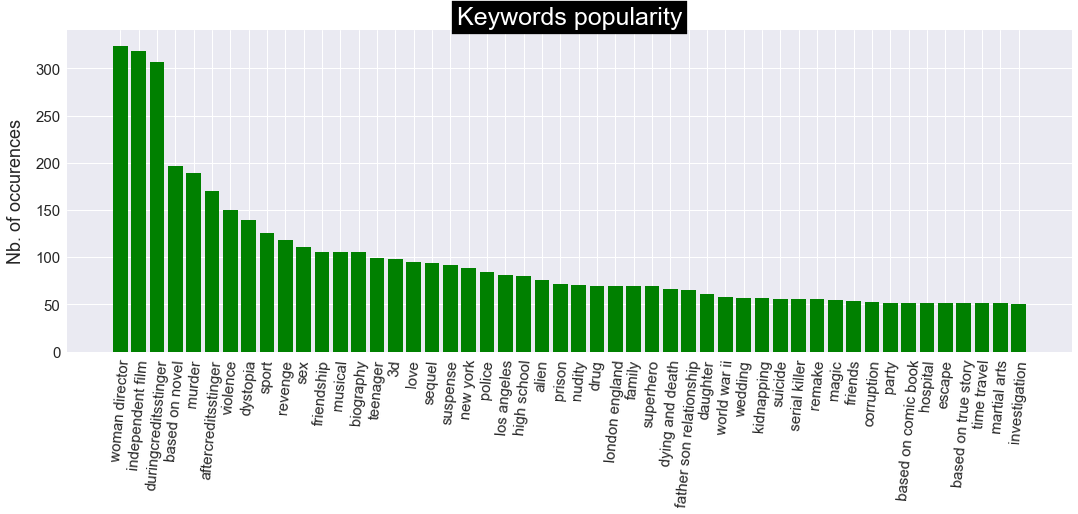

In [10]:
fig = plt.figure(1, figsize=(18,13))

trunc_occurences = keyword_occurences[0:50]

#_____________________________________________
#  HISTOGRAMS
ax2 = fig.add_subplot(2,1,2)
y_axis = [i[1] for i in trunc_occurences]
x_axis = [k for k,i in enumerate(trunc_occurences)]
x_label = [i[0] for i in trunc_occurences]
plt.xticks(rotation=85, fontsize = 15)
plt.yticks(fontsize = 15)
plt.xticks(x_axis, x_label)
plt.ylabel("Nb. of occurences", fontsize = 18, labelpad = 10)
ax2.bar(x_axis, y_axis, align = 'center', color='g')
#_______________________
plt.title("Keywords popularity",bbox={'facecolor':'k', 'pad':5},color='w',fontsize = 25)
plt.show()

In [11]:
df_initial['decade'] = df_initial['title_year'].apply(lambda x:((x-1900)//10)*10)
#__________________________________________________________________
# function that extract statistical parameters from a grouby objet:
def get_stats(gr):
    return {'min':gr.min(),'max':gr.max(),'count': gr.count(),'mean':gr.mean()}
#______________________________________________________________
# Creation of a dataframe with statitical infos on each decade:
test = df_initial['title_year'].groupby(df_initial['decade']).apply(get_stats).unstack()
test

,count,max,mean,min
decade,,,,
10.0,1.0,1916.0,1916.000000,1916.0
20.0,4.0,1929.0,1927.500000,1925.0
30.0,15.0,1939.0,1935.733333,1930.0
40.0,25.0,1949.0,1944.560000,1940.0
50.0,27.0,1959.0,1954.296296,1950.0
60.0,71.0,1969.0,1965.028169,1960.0
70.0,109.0,1979.0,1974.944954,1970.0
80.0,278.0,1989.0,1984.715827,1980.0
90.0,778.0,1999.0,1996.141388,1990.0


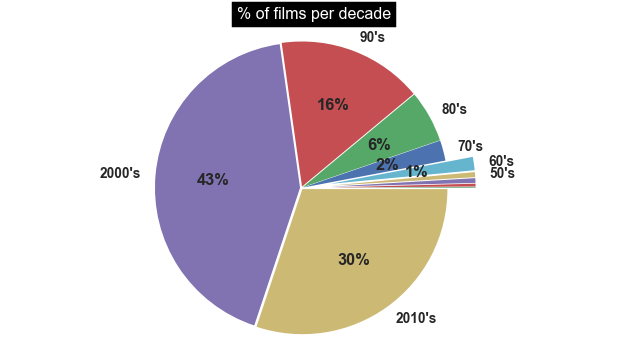

In [12]:
sns.set_context("poster", font_scale=0.85)
#_______________________________
# funtion used to set the labels
def label(s):
    val = (1900 + s, s)[s < 100]
    chaine = '' if s < 50 else "{}'s".format(int(val))
    return chaine
#____________________________________
plt.rc('font', weight='bold')
f, ax = plt.subplots(figsize=(11, 6))
labels = [label(s) for s in  test.index]
sizes  = test['count'].values
explode = [0.2 if sizes[i] < 100 else 0.01 for i in range(11)]
ax.pie(sizes, explode = explode, labels=labels,
       autopct = lambda x:'{:1.0f}%'.format(x) if x > 1 else '',
       shadow=False, startangle=0)
ax.axis('equal')
ax.set_title('% of films per decade',
             bbox={'facecolor':'k', 'pad':5},color='w', fontsize=16);
df_initial.drop('decade', axis=1, inplace = True)
plt.show()

In [13]:
genre_labels = set()
for s in df_initial['genres'].str.split('|').values:
    genre_labels = genre_labels.union(set(s))

In [14]:
genre_occurences, dum = count_word(df_initial, 'genres', genre_labels)
genre_occurences[:5]

[['Drama', 2297],
 ['Comedy', 1722],
 ['Thriller', 1274],
 ['Action', 1154],
 ['Romance', 894]]

In [15]:
genre_occurences = [x for x in genre_occurences if x[0]]

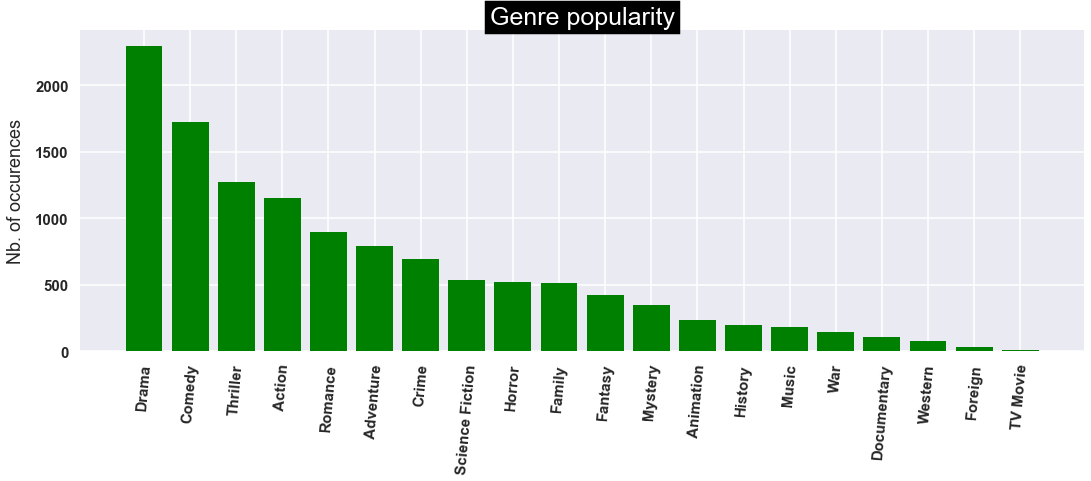

In [16]:
fig = plt.figure(1, figsize=(18,13))

trunc_occurences = genre_occurences[0:50]

ax2 = fig.add_subplot(2,1,2)
y_axis = [i[1] for i in trunc_occurences]
x_axis = [k for k,i in enumerate(trunc_occurences)]
x_label = [i[0] for i in trunc_occurences]
plt.xticks(rotation=85, fontsize = 15)
plt.yticks(fontsize = 15)
plt.xticks(x_axis, x_label)
plt.ylabel("Nb. of occurences", fontsize = 18, labelpad = 10)
ax2.bar(x_axis, y_axis, align = 'center', color='g')
#_______________________
plt.title("Genre popularity",bbox={'facecolor':'k', 'pad':5},color='w',fontsize = 25)
plt.show()

# Cleaning the Data

#### 2.1 Checking and removing for duplicate Data

In [17]:
doubled_entries = df_initial[df_initial.id.duplicated()]
#doubled_entries = df_initial[df_initial.director_name.duplicated()]
#doubled_entries.shape
doubled_entries

,budget,genres,homepage,id,plot_keywords,language,original_title,overview,popularity,production_companies,...,tagline,movie_title,vote_average,num_voted_users,title_year,country,director_name,actor_1_name,actor_2_name,actor_3_name


In [18]:
PS = nltk.stem.PorterStemmer()

In [19]:
#df_temp = df_initial.drop_duplicates()
df_temp = df_initial

In [20]:
list_var_duplicates = ['movie_title', 'title_year', 'director_name']

In [21]:
liste_duplicates = df_temp['movie_title'].map(df_temp['movie_title'].value_counts() > 1)
print("Nb. of duplicate entries: {}".format(len(df_temp[liste_duplicates][list_var_duplicates])))

Nb. of duplicate entries: 6


In [22]:
df_temp[liste_duplicates][list_var_duplicates].sort_values('movie_title')

,movie_title,title_year,director_name
1359,Batman,1989.0,Tim Burton
4267,Batman,1966.0,Leslie H. Martinson
3647,Out of the Blue,1980.0,Dennis Hopper
3693,Out of the Blue,2006.0,Robert Sarkies
972,The Host,2013.0,Andrew Niccol
2877,The Host,2006.0,Bong Joon-ho


In [23]:
pd.DataFrame(df_initial.iloc[2166] != df_initial.iloc[1319], columns = ['similar columns'])

,similar columns
budget,True
genres,True
homepage,True
id,True
plot_keywords,True
language,False
original_title,True
overview,True
popularity,True
production_companies,True


In [24]:
df_duplicate_cleaned = df_temp.drop_duplicates(subset=list_var_duplicates, keep='last')
#df_duplicate_cleaned = df_temp
df_temp[liste_duplicates][list_var_duplicates].sort_values('movie_title')

,movie_title,title_year,director_name
1359,Batman,1989.0,Tim Burton
4267,Batman,1966.0,Leslie H. Martinson
3647,Out of the Blue,1980.0,Dennis Hopper
3693,Out of the Blue,2006.0,Robert Sarkies
972,The Host,2013.0,Andrew Niccol
2877,The Host,2006.0,Bong Joon-ho


#### 2.2 Cleaning of the keywords
Keywords will play an important role in the functioning of the engine. Indeed, recommendations will be based on similarity between films and to gauge such similarities, I will look for films described by the same keywords. Hence, the content of the plot_keywords variable deserves some attention since it will be extensively used.


##### 2.2.1 Grouping by roots
I collect the keywords that appear in the plot_keywords variable. This list is then cleaned using the NLTK package. Finally, I look for the number of occurence of the various keywords

In [25]:
# Collect the keywords
#----------------------
def keywords_inventory(dataframe, colonne = 'plot_keywords'):
    
    keywords_roots  = dict()  # collect the words / root
                              # the root is the key and the list of words starting with the root are the values
    keywords_select = dict()  # association: root <-> keyword
    category_keys = []
    icount = 0
    for s in dataframe[colonne]:
        if pd.isnull(s): continue
        for t in s.split('|'):
            t = t.lower()
            racine = PS.stem(t)
            #print("word", t, "----- root", racine)
            if racine in keywords_roots:                
                keywords_roots[racine].add(t)
            else:
                keywords_roots[racine] = {t}
    
    for s in keywords_roots.keys():
        if len(keywords_roots[s]) > 1:  
            min_length = 1000
            for k in keywords_roots[s]:
                if len(k) < min_length:
                    clef = k ; min_length = len(k)            
            category_keys.append(clef)
            keywords_select[s] = clef
        else:
            category_keys.append(list(keywords_roots[s])[0])
            keywords_select[s] = list(keywords_roots[s])[0]
                   
    print("Nb of keywords in variable '{}': {}".format(colonne,len(category_keys)))
    return category_keys, keywords_roots, keywords_select

In [26]:
keywords, keywords_roots, keywords_select = keywords_inventory(df_duplicate_cleaned, colonne = 'plot_keywords')

Nb of keywords in variable 'plot_keywords': 9474


In [27]:
# Plot of a sample of keywords that appear in close varieties 
#------------------------------------------------------------
icount = 0
for s in keywords_roots.keys():
    if len(keywords_roots[s]) > 1: 
        icount += 1
        if icount < 15: print(icount, keywords_roots[s], len(keywords_roots[s]))

1 {'alienation', 'alien'} 2
2 {'spy', 'spying'} 2
3 {'vigilantism', 'vigilante'} 2
4 {'terrorism', 'terror'} 2
5 {'flood', 'flooding'} 2
6 {'spider', 'spiders'} 2
7 {'horse', 'horses'} 2
8 {'musical', 'music'} 2
9 {'animation', 'anime', 'animal'} 3
10 {'compass', 'compassion'} 2
11 {'training', 'train'} 2
12 {'sail', 'sailing'} 2
13 {'time travel', 'time traveler'} 2
14 {'orcs', 'orc'} 2


In [28]:
# Replacement of the keywords by the main form
#----------------------------------------------
def remplacement_df_keywords(df, dico_remplacement, roots = False):
    df_new = df.copy(deep = True)
    for index, row in df_new.iterrows():
        chaine = row['plot_keywords']
        if pd.isnull(chaine): continue
        nouvelle_liste = []
        for s in chaine.split('|'): 
            clef = PS.stem(s) if roots else s
            if clef in dico_remplacement.keys():
                nouvelle_liste.append(dico_remplacement[clef])
            else:
                nouvelle_liste.append(s)       
        df_new.set_value(index, 'plot_keywords', '|'.join(nouvelle_liste)) 
    return df_new

In [29]:
# Replacement of the keywords by the main keyword
#-------------------------------------------------
df_keywords_cleaned = remplacement_df_keywords(df_duplicate_cleaned, keywords_select,
                                               roots = True)
#df_keywords_cleaned

In [30]:
# Count of the keywords occurences
#----------------------------------
keyword_occurences, keywords_count = count_word(df_keywords_cleaned,'plot_keywords',keywords)
keyword_occurences[:5]

[['', 412],
 ['woman director', 324],
 ['independent film', 318],
 ['duringcreditsstinger', 307],
 ['based on novel', 197]]

###### 2.2.2 Groups of synonyms
I clean the list of keywords in two steps. As a first step, I suppress the keywords that appear less that 5 times and replace them by a synomym of higher frequency. As a second step, I suppress all the keywords that appear in less than 3 films

In [31]:
# check if 'mot' is a key of 'key_count' with a test on the number of occurences   
#----------------------------------------------------------------------------------
def test_keyword(mot, key_count, threshold):
    return (False , True)[key_count.get(mot, 0) >= threshold]

In [33]:
def get_synonymes(mot_cle):
    lemma = set()
    for ss in wordnet.synsets(mot_cle):
        for w in ss.lemma_names():
            #_______________________________
            # We just get the 'nouns':
            index = ss.name().find('.')+1
            if ss.name()[index] == 'n': lemma.add(w.lower().replace('_',' '))
    return lemma   

In [34]:
mot_cle = 'alien'
lemma = get_synonymes(mot_cle)
for s in lemma:
    print(' "{:<30}" in keywords list -> {} {}'.format(s, s in keywords,
                                                keywords_count[s] if s in keywords else 0 ))

 "foreigner                     " in keywords list -> False 0
 "noncitizen                    " in keywords list -> False 0
 "alien                         " in keywords list -> True 80
 "stranger                      " in keywords list -> True 7
 "outlander                     " in keywords list -> False 0
 "extraterrestrial              " in keywords list -> True 4
 "unknown                       " in keywords list -> False 0
 "extraterrestrial being        " in keywords list -> False 0


In [35]:
def test_keyword(mot, key_count, threshold):
    return (False , True)[key_count.get(mot, 0) >= threshold]

In [36]:
keyword_occurences.sort(key = lambda x:x[1], reverse = False)
key_count = dict()
for s in keyword_occurences:
    key_count[s[0]] = s[1]
#__________________________________________________________________________
# Creation of a dictionary to replace keywords by higher frequency keywords
remplacement_mot = dict()
icount = 0
for index, [mot, nb_apparitions] in enumerate(keyword_occurences):
    if nb_apparitions > 5: continue  # only the keywords that appear less than 5 times
    lemma = get_synonymes(mot)
    if len(lemma) == 0: continue     # case of the plurals
    #_________________________________________________________________
    liste_mots = [(s, key_count[s]) for s in lemma 
                  if test_keyword(s, key_count, key_count[mot])]
    liste_mots.sort(key = lambda x:(x[1],x[0]), reverse = True)    
    if len(liste_mots) <= 1: continue       # no replacement
    if mot == liste_mots[0][0]: continue    # replacement by himself
    icount += 1
    if  icount < 8:
        print('{:<12} -> {:<12} (init: {})'.format(mot, liste_mots[0][0], liste_mots))    
    remplacement_mot[mot] = liste_mots[0][0]

print(90*'_'+'\n'+'The replacement concerns {}% of the keywords.'
      .format(round(len(remplacement_mot)/len(keywords)*100,2)))

narcism      -> narcissism   (init: [('narcissism', 1), ('narcism', 1)])
apparition   -> shadow       (init: [('shadow', 3), ('phantom', 3), ('apparition', 1)])
macao        -> macau        (init: [('macau', 1), ('macao', 1)])
regent       -> trustee      (init: [('trustee', 1), ('regent', 1)])
civilization -> culture      (init: [('culture', 2), ('civilization', 1)])
ark          -> ark of the covenant (init: [('ark of the covenant', 2), ('ark', 1)])
automaton    -> zombie       (init: [('zombie', 45), ('robot', 27), ('automaton', 1)])
__________________________________________________________________________________________
The replacement concerns 5.95% of the keywords.


In [37]:
# 2 successive replacements
#---------------------------
print('Keywords that appear both in keys and values:'.upper()+'\n'+45*'-')
icount = 0
for s in remplacement_mot.values():
    if s in remplacement_mot.keys():
        icount += 1
        if icount < 10: print('{:<20} -> {:<20}'.format(s, remplacement_mot[s]))

for key, value in remplacement_mot.items():
    if value in remplacement_mot.keys():
        remplacement_mot[key] = remplacement_mot[value] 

KEYWORDS THAT APPEAR BOTH IN KEYS AND VALUES:
---------------------------------------------
shadow               -> dark                
failure              -> loser               
leech                -> parasite            
carnival             -> circus              
pit                  -> hell                
drawing              -> lottery             
deal                 -> mountain            
twist                -> crook               
pest                 -> plague              


In [38]:
# replacement of keyword varieties by the main keyword
#----------------------------------------------------------
df_keywords_synonyms = \
            remplacement_df_keywords(df_keywords_cleaned, remplacement_mot, roots = False)   
keywords, keywords_roots, keywords_select = \
            keywords_inventory(df_keywords_synonyms, colonne = 'plot_keywords')

Nb of keywords in variable 'plot_keywords': 8911


In [39]:

# New count of keyword occurences
#-------------------------------------
new_keyword_occurences, keywords_count = count_word(df_keywords_synonyms,
                                                    'plot_keywords',keywords)
new_keyword_occurences[:5]

[['', 412],
 ['woman director', 324],
 ['independent film', 318],
 ['duringcreditsstinger', 307],
 ['based on novel', 197]]

In [40]:

# deletion of keywords with low frequencies
#-------------------------------------------
def remplacement_df_low_frequency_keywords(df, keyword_occurences):
    df_new = df.copy(deep = True)
    key_count = dict()
    for s in keyword_occurences: 
        key_count[s[0]] = s[1]    
    for index, row in df_new.iterrows():
        chaine = row['plot_keywords']
        if pd.isnull(chaine): continue
        nouvelle_liste = []
        for s in chaine.split('|'): 
            if key_count.get(s, 4) > 3: nouvelle_liste.append(s)
        df_new.set_value(index, 'plot_keywords', '|'.join(nouvelle_liste))
    return df_new

In [41]:
# Creation of a dataframe where keywords of low frequencies are suppressed
#-------------------------------------------------------------------------
df_keywords_occurence = \
    remplacement_df_low_frequency_keywords(df_keywords_synonyms, new_keyword_occurences)
keywords, keywords_roots, keywords_select = \
    keywords_inventory(df_keywords_occurence, colonne = 'plot_keywords')  

Nb of keywords in variable 'plot_keywords': 2121


In [42]:
# New keywords count
#-------------------
new_keyword_occurences, keywords_count = count_word(df_keywords_occurence,
                                                    'plot_keywords',keywords)
new_keyword_occurences[:5]

[['', 508],
 ['woman director', 324],
 ['independent film', 318],
 ['duringcreditsstinger', 307],
 ['based on novel', 197]]

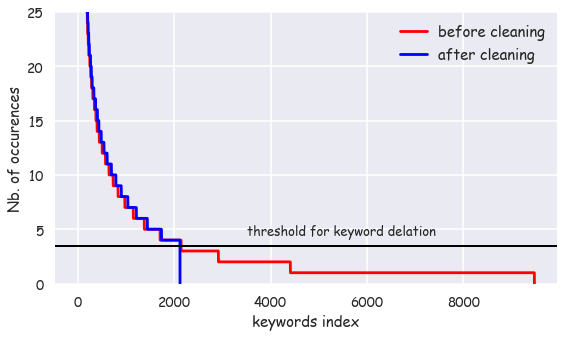

In [43]:
# Graph of keyword occurences
#----------------------------
font = {'family' : 'fantasy', 'weight' : 'normal', 'size'   : 15}
mpl.rc('font', **font)

keyword_occurences.sort(key = lambda x:x[1], reverse = True)

y_axis = [i[1] for i in keyword_occurences]
x_axis = [k for k,i in enumerate(keyword_occurences)]

new_y_axis = [i[1] for i in new_keyword_occurences]
new_x_axis = [k for k,i in enumerate(new_keyword_occurences)]

f, ax = plt.subplots(figsize=(9, 5))
ax.plot(x_axis, y_axis, 'r-', label='before cleaning')
ax.plot(new_x_axis, new_y_axis, 'b-', label='after cleaning')

# Now add the legend with some customizations.
legend = ax.legend(loc='upper right', shadow=True)
frame = legend.get_frame()
frame.set_facecolor('0.90')
for label in legend.get_texts():
    label.set_fontsize('medium')
            
plt.ylim((0,25))
plt.axhline(y=3.5, linewidth=2, color = 'k')
plt.xlabel("keywords index", family='fantasy', fontsize = 15)
plt.ylabel("Nb. of occurences", family='fantasy', fontsize = 15)
#plt.suptitle("Nombre d'occurences des mots clés", fontsize = 18, family='fantasy')
plt.text(3500, 4.5, 'threshold for keyword delation', fontsize = 13)
plt.show()

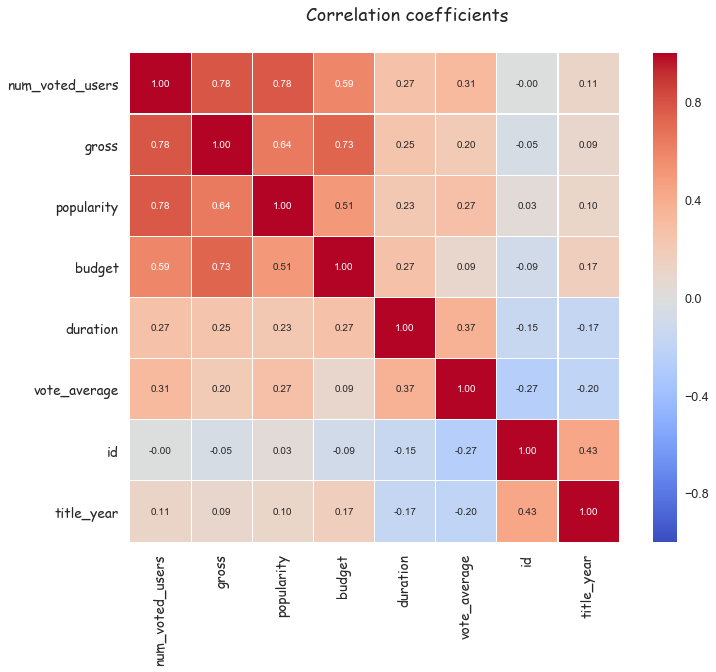

In [44]:
f, ax = plt.subplots(figsize=(12, 9))
#_____________________________
# calculations of correlations
corrmat = df_keywords_occurence.dropna(how='any').corr()
#________________________________________
k = 17 # number of variables for heatmap
cols = corrmat.nlargest(k, 'num_voted_users')['num_voted_users'].index
cm = np.corrcoef(df_keywords_occurence[cols].dropna(how='any').values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True,
                 fmt='.2f', annot_kws={'size': 10}, linewidth = 0.1, cmap = 'coolwarm',
                 yticklabels=cols.values, xticklabels=cols.values)
f.text(0.5, 0.93, "Correlation coefficients", ha='center', fontsize = 18, family='fantasy')
plt.show()

### 2.4 Missing Values
#### 2.4.1 Computing the filling factor

In [45]:

LOST_COLUMNS = [
    'actor_1_facebook_likes',
    'actor_2_facebook_likes',
    'actor_3_facebook_likes',
    'aspect_ratio',
    'cast_total_facebook_likes',
    'color',
    'content_rating',
    'director_facebook_likes',
    'facenumber_in_poster',
    'movie_facebook_likes',
    'movie_imdb_link',
    'num_critic_for_reviews',
    'num_user_for_reviews'
                ]

In [46]:
new_col_order = ['movie_title', 'title_year', 'genres', 'plot_keywords', 
                 'director_name', 'actor_1_name', 'actor_2_name', 'actor_3_name',
                 'director_facebook_likes', 'actor_1_facebook_likes', 'actor_2_facebook_likes',
                 'actor_3_facebook_likes', 'movie_facebook_likes', 'num_critic_for_reviews', 
                 'num_user_for_reviews', 'num_voted_users', 'language', 'country',
                 'imdb_score', 'movie_imdb_link', 'color', 'duration', 'gross', ]
new_col_order = [col for col in new_col_order if col not in LOST_COLUMNS]
new_col_order = [IMDB_COLUMNS_TO_REMAP[col] if col in IMDB_COLUMNS_TO_REMAP else col
                 for col in new_col_order]
new_col_order = [TMDB_TO_IMDB_SIMPLE_EQUIVALENCIES[col] if col in TMDB_TO_IMDB_SIMPLE_EQUIVALENCIES else col
                 for col in new_col_order]
df_var_cleaned = df_keywords_occurence[new_col_order]

In [47]:

missing_df = df_var_cleaned.isnull().sum(axis=0).reset_index()
missing_df.columns = ['column_name', 'missing_count']
missing_df['filling_factor'] = (df_var_cleaned.shape[0] 
                                - missing_df['missing_count']) / df_var_cleaned.shape[0] * 100
missing_df = missing_df.sort_values('filling_factor').reset_index(drop = True)
missing_df

,column_name,missing_count,filling_factor
0,country,174,96.377264
1,actor_3_name,93,98.063710
2,language,86,98.209452
3,actor_2_name,63,98.688320
4,actor_1_name,53,98.896523
5,director_name,30,99.375390
6,duration,2,99.958359
7,title_year,1,99.979180
8,movie_title,0,100.000000
9,genres,0,100.000000


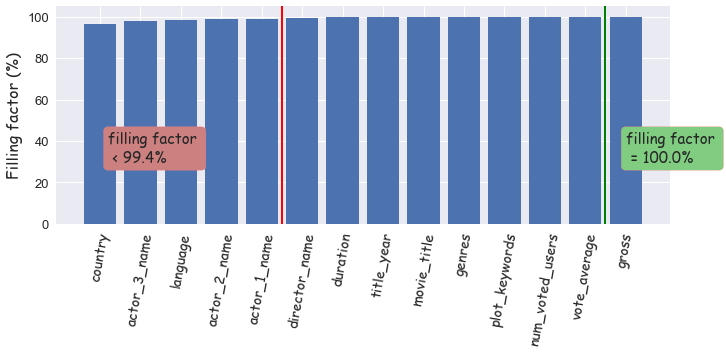

In [48]:
y_axis = missing_df['filling_factor'] 
x_label = missing_df['column_name']
x_axis = missing_df.index

fig = plt.figure(figsize=(11, 4))
plt.xticks(rotation=80, fontsize = 14)
plt.yticks(fontsize = 13)

N_thresh = 5
plt.axvline(x=N_thresh-0.5, linewidth=2, color = 'r')
plt.text(N_thresh-4.8, 30, 'filling factor \n < {}%'.format(round(y_axis[N_thresh],1)),
         fontsize = 15, family = 'fantasy', bbox=dict(boxstyle="round",
                   ec=(1.0, 0.5, 0.5),
                   fc=(0.8, 0.5, 0.5)))
N_thresh = 13
plt.axvline(x=N_thresh-0.5, linewidth=2, color = 'g')
plt.text(N_thresh, 30, 'filling factor \n = {}%'.format(round(y_axis[N_thresh],1)),
         fontsize = 15, family = 'fantasy', bbox=dict(boxstyle="round",
                   ec=(1., 0.5, 0.5),
                   fc=(0.5, 0.8, 0.5)))

plt.xticks(x_axis, x_label,family='fantasy', fontsize = 14 )
plt.ylabel('Filling factor (%)', family='fantasy', fontsize = 16)
plt.bar(x_axis, y_axis);
plt.show()

#### 2.4.2 Extracting keywords from the title
As previously outlined, keywords will play an important role in the functioning of the engine. Hence, I try to fill missing values in the plot_keywords variable using the words of the title. To do so, I create the list of synonyms of all the words contained in the title and I check if any of these synonyms are already in the keyword list. When it is the case, I add this keyword to the entry:

In [49]:

df_filling = df_var_cleaned.copy(deep=True)
icount = 0
for index, row in df_filling[df_filling['plot_keywords'].isnull()].iterrows():
    icount += 1
    liste_mot = row['movie_title'].strip().split()
    new_keyword = []
    for s in liste_mot:
        lemma = get_synonymes(s)
        for t in list(lemma):
            if t in keywords: 
                new_keyword.append(t)                
    if new_keyword and icount < 15: 
        print('{:<50} -> {:<30}'.format(row['movie_title'], str(new_keyword)))
    if new_keyword:
        df_filling.set_value(index, 'plot_keywords', '|'.join(new_keyword)) 


#### 2.4.3 Imputing from regressions
In Section 2.4, I had a look at the correlation between variables and found that a few of them showed some degree of correlation, with a Pearson's coefficient > 0.5:

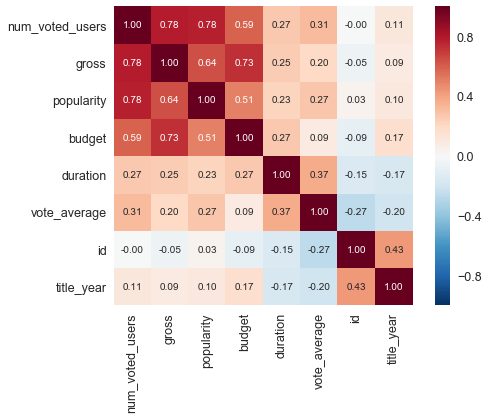

In [50]:
cols = corrmat.nlargest(9, 'num_voted_users')['num_voted_users'].index
cm = np.corrcoef(df_keywords_occurence[cols].dropna(how='any').values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True,
                 fmt='.2f', annot_kws={'size': 10}, 
                 yticklabels=cols.values, xticklabels=cols.values)
plt.show()

In [51]:
def variable_linreg_imputation(df, col_to_predict, ref_col):
    regr = linear_model.LinearRegression()
    test = df[[col_to_predict,ref_col]].dropna(how='any', axis = 0)
    X = np.array(test[ref_col])
    Y = np.array(test[col_to_predict])
    X = X.reshape(len(X),1)
    Y = Y.reshape(len(Y),1)
    regr.fit(X, Y)
    
    test = df[df[col_to_predict].isnull() & df[ref_col].notnull()]
    for index, row in test.iterrows():
        value = float(regr.predict(row[ref_col]))
        df.set_value(index, col_to_predict, value)

In [52]:
variable_linreg_imputation(df_filling, 'gross', 'num_voted_users')

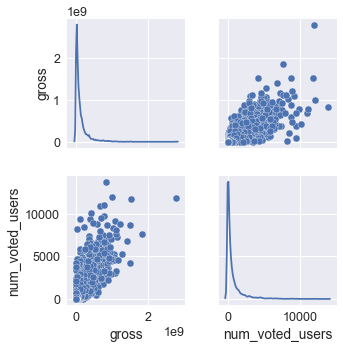

In [53]:
sns.set(font_scale=1.25)
cols = ['gross', 'num_voted_users']
sns.pairplot(df_filling.dropna(how='any')[cols],diag_kind='kde', size = 2.5)
plt.show();

In [57]:
df = df_filling.copy(deep=True)
df.reset_index(inplace = True, drop = True)

## 3.1 Basic functioning of the engine
order to build the recommendation engine, I will basically proceed in two steps:
1. determine N films with a content similar to the entry provided by the user
2. select the 5 most popular films among these films

#### 3.1.1 Similarity
When builing the engine, the first step thus consists in defining a criteria that would tell us how close two films are. To do so, I start from the description of the film that was selected by the user: from it, I get the director name, the names of the actors and a few keywords. 

#### 3.1.2 Popularity
According to similarities between entries, we get a list of films. At this stage, I select 5 films from this list and, to do so, I give a score for every entry. I decide de compute the score according to 3 criteria:
1. the IMDB score
2. the number of votes the entry received
3. the year of release

In [58]:
gaussian_filter = lambda x,y,sigma: math.exp(-(x-y)**2/(2*sigma**2))

In [59]:
# Collecting variables values for Acrtors, Director and Plot keywords
def entry_variables(df, id_entry): 
    col_labels = []    
    if pd.notnull(df['director_name'].iloc[id_entry]):
        for s in df['director_name'].iloc[id_entry].split('|'):
            col_labels.append(s)
            
    for i in range(3):
        column = 'actor_NUM_name'.replace('NUM', str(i+1))
        if pd.notnull(df[column].iloc[id_entry]):
            for s in df[column].iloc[id_entry].split('|'):
                col_labels.append(s)
                
    if pd.notnull(df['plot_keywords'].iloc[id_entry]):
        for s in df['plot_keywords'].iloc[id_entry].split('|'):
            col_labels.append(s)
    return col_labels

In [60]:
#add the data collected in the dataframe and compare them to match the data set we already have for related movies.
def add_variables(df, REF_VAR):    
    for s in REF_VAR: df[s] = pd.Series([0 for _ in range(len(df))])
    colonnes = ['genres', 'actor_1_name', 'actor_2_name',
                'actor_3_name', 'director_name', 'plot_keywords']
    for categorie in colonnes:
        for index, row in df.iterrows():
            if pd.isnull(row[categorie]): continue
            for s in row[categorie].split('|'):
                if s in REF_VAR: df.set_value(index, s, 1)            
    return df

In [61]:
# This function computes the movies that match the users inputs.
def recommand(df, id_entry):    
    df_copy = df.copy(deep = True)    
    liste_genres = set()
    for s in df['genres'].str.split('|').values:
        liste_genres = liste_genres.union(set(s))    
    #_____________________________________________________
    # Create additional variables to check the similarity
    variables = entry_variables(df_copy, id_entry)
    variables += list(liste_genres)
    df_new = add_variables(df_copy, variables)
    #____________________________________________________________________________________
    # determination of the closest neighbors: the distance is calculated / new variables
    X = df_new.as_matrix(variables)
    nbrs = NearestNeighbors(n_neighbors=31, algorithm='auto', metric='euclidean').fit(X)

    distances, indices = nbrs.kneighbors(X)    
    xtest = df_new.iloc[id_entry].as_matrix(variables)
    xtest = xtest.reshape(1, -1)

    distances, indices = nbrs.kneighbors(xtest)

    return indices[0][:]
    

In [63]:

def extract_parameters(df, liste_films):     
    parametres_films = ['_' for _ in range(31)]
    i = 0
    max_users = -1
    for index in liste_films:
        parametres_films[i] = list(df.iloc[index][['movie_title', 'title_year',
                                        'imdb_score', 'num_user_for_reviews', 
                                        'num_voted_users']])
        parametres_films[i].append(index)
        max_users = max(max_users, parametres_films[i][4] )
        i += 1
        
    title_main = parametres_films[0][0]
    annee_ref  = parametres_films[0][1]
    parametres_films.sort(key = lambda x:critere_selection(title_main, max_users,
                                    annee_ref, x[0], x[1], x[2], x[4]), reverse = True)

    return parametres_films 

In [64]:
# Function to compute the sequel of the movie
def sequel(titre_1, titre_2):    
    if fuzz.ratio(titre_1, titre_2) > 50 or fuzz.token_set_ratio(titre_1, titre_2) > 50:
        return True
    else:
        return False

In [65]:
# to reccomend the top 5 movies that match the criteria we compute and 
#score each movie on the basis of ratings on IMDB, the movie votes and the year of release as mentioned before
def critere_selection(title_main, max_users, annee_ref, titre, annee, imdb_score, votes):    
    if pd.notnull(annee_ref):
        facteur_1 = gaussian_filter(annee_ref, annee, 20)
    else:
        facteur_1 = 1        

    sigma = max_users * 1.0

    if pd.notnull(votes):
        facteur_2 = gaussian_filter(votes, max_users, sigma)
    else:
        facteur_2 = 0
        
    if sequel(title_main, titre):
        note = 0
    else:
        note = imdb_score**2 * facteur_1 * facteur_2
    
    return note

In [66]:
# add the movies with highest comparatative ratings in the list
def add_to_selection(film_selection, parametres_films):    
    film_list = film_selection[:]
    icount = len(film_list)    
    for i in range(31):
        already_in_list = False
        for s in film_selection:
            if s[0] == parametres_films[i][0]: already_in_list = True
            if sequel(parametres_films[i][0], s[0]): already_in_list = True            
        if already_in_list: continue
        icount += 1
        if icount <= 5:
            film_list.append(parametres_films[i])
    return film_list

In [67]:
#Remove the sequels from the list prepared
def remove_sequels(film_selection):    
    removed_from_selection = []
    for i, film_1 in enumerate(film_selection):
        for j, film_2 in enumerate(film_selection):
            if j <= i: continue 
            if sequel(film_1[0], film_2[0]): 
                last_film = film_2[0] if film_1[1] < film_2[1] else film_1[0]
                removed_from_selection.append(last_film)

    film_list = [film for film in film_selection if film[0] not in removed_from_selection]

    return film_list   

In [68]:
def find_similarities(df, id_entry, del_sequels = True, verbose = False):    
    if verbose: 
        print(90*'_' + '\n' + "QUERY: films similar to id={} -> '{}'".format(id_entry,
                                df.iloc[id_entry]['movie_title']))
    #____________________________________
    liste_films = recommand(df, id_entry)
    #__________________________________
    # Create a list of 31 films
    parametres_films = extract_parameters(df, liste_films)
    #_______________________________________
    # Select 5 films from this list
    film_selection = []
    film_selection = add_to_selection(film_selection, parametres_films)
    #__________________________________
    # delation of the sequels
    if del_sequels: film_selection = remove_sequels(film_selection)
    #______________________________________________
    # add new films to complete the list
    film_selection = add_to_selection(film_selection, parametres_films)
    #_____________________________________________
    selection_titres = []
    for i,s in enumerate(film_selection):
        selection_titres.append([s[0].replace(u'\xa0', u''), s[5]])
        if verbose: print("nº{:<2}     -> {:<30}".format(i+1, s[0]))

    return selection_titres

#### 3.3 Making meaningful recommendations

While building the recommendation engine, we are quickly faced to a big issue: the existence of sequels make that some recommendations may seem quite dumb ... As an exemple, somebody who enjoyed "Pirates of the Caribbean: Dead Man's Chest" would probably not like to be adviced to watch this:

In [69]:
dum = find_similarities(df, 12, del_sequels = False, verbose = True)

__________________________________________________________________________________________
QUERY: films similar to id=12 -> 'Pirates of the Caribbean: Dead Man's Chest'


NameError: name 'fuzz' is not defined

In [70]:
selection = dict()
for i in range(0, 20, 3):
    selection[i] = find_similarities(df, i, del_sequels = True, verbose = True)

__________________________________________________________________________________________
QUERY: films similar to id=0 -> 'Avatar'


NameError: name 'fuzz' is not defined

# 4. Conclusion: possible improvements and points to address
Finally a few things were not considered when building the engine and they should deserve some attention:
the language of the film was not checked: in fact, this could be important to get sure that the films recommended are in the same language than the one choosen by the user
another point concerns the replacement of the keywords by more frequent synonyms. In some cases, it was shown that the synonyms selected had a different meaning that the original word. Definitely, the whole process might deserve more attention and be improved.
another improvement could be to create a list of connections between actors to see which are the actors that use to play in similar movies (I started an analysis in that direction in another notebook). Hence, rather than only looking at the actors who are in the film selected by the user, we could enlarge this list by a few more people. Something similar could be done also with the directors.
extend the detections of sequels to films that don't share similar titles (e.g. James Bond serie)